# Direct ingestion of GTEx V8

Expression Atlas only provides GTEx V7, released 2016-01-15. In this notebook, we ingest GTEx V8, released 2017-06-05. As of 2023-09-29, this is the latest available version. Release notes and differences between tissues can be found here: https://gtexportal.org/home/releaseInfoPage.

## 1. Prepare the environment

In [1]:
! python3 -m venv env
! source env/bin/activate
! pip -q install --upgrade numpy pandas rpy2

DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [23]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Enables the %%R magic.
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## 2. Download, ingest, and examine the data

In [3]:
! wget -q -O gtex_v8.gct.gz "https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz"

In [4]:
df = pd.read_csv("gtex_v8.gct.gz", sep='\t', skiprows=2)
df.drop(columns=["Description"], inplace=True)
df["Name"] = df["Name"].str.split('.').str[0]
df.set_index(keys=["Name"], inplace=True)
df

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.166403,0.000000,0.000000,0.000000,0.00000
ENSG00000227232,4.064030,3.371110,2.68549,4.04762,3.90076,3.639630,5.16375,1.43859,1.69285,1.566050,...,5.932980,6.13265,4.193780,5.926310,3.062480,4.702530,6.272550,7.190010,5.745540,2.64743
ENSG00000278267,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
ENSG00000243485,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.024264,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.054223,0.000000,0.000000,0.000000,0.00000
ENSG00000237613,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,3517.220000,3598.090000,6637.79000,6374.49000,4972.73000,4635.000000,8275.20000,9631.77000,8319.14000,11516.600000,...,8919.460000,8113.22000,9764.490000,5477.360000,9628.750000,1676.590000,2520.410000,3644.000000,2237.430000,960.29100
ENSG00000210194,11.903800,11.203400,24.41390,22.65940,20.58800,18.257600,27.50560,40.58860,31.35490,78.695300,...,32.932100,31.33400,35.456000,24.934900,33.496300,2.871770,5.795670,10.370100,5.724510,3.49736
ENSG00000198727,23839.100000,25511.700000,28799.40000,12919.40000,15943.20000,13051.500000,23663.20000,32931.80000,28346.70000,40960.000000,...,19058.200000,17223.10000,24521.300000,11578.600000,27193.100000,15337.800000,19868.500000,15025.000000,12803.400000,2305.49000


## 3. Filter out genes with very low expression

Genes with very low expression tend to generate noisy data. One particular case is an expression vector where one tissue has expression of 0.1 TPM and all the other ones are 0.0 exactly. This causes the gene to be called as extremely specifically expressed, even though most of these issues are just false discoveries.

A common threshold used for filtering out genes with very low expression is to filter out those where expression in all tissues is less than 1.0 TPM. This is also used by HPA, and supported by internal investigations into quality control.

In [5]:
THRESHOLD = 1.0
max_expr_across_tissues = df.max(axis=1)
expr_level_mask = max_expr_across_tissues >= THRESHOLD
df = df[expr_level_mask]
df

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232,4.064030,3.371110,2.685490,4.04762,3.900760,3.639630,5.16375,1.438590,1.692850,1.566050,...,5.932980,6.132650,4.193780,5.926310,3.062480,4.702530,6.272550,7.190010,5.745540,2.647430
ENSG00000268903,3.241590,5.154330,3.668540,3.64269,3.601800,1.461070,3.50280,1.400810,1.330200,1.038280,...,5.855510,6.085610,4.685720,44.899900,3.606070,34.894400,9.503380,4.143990,8.724360,134.312000
ENSG00000269981,5.137590,7.798020,6.503060,6.23226,5.241380,2.570040,5.45536,1.223390,1.031000,1.248690,...,9.923110,10.646100,8.385520,75.784400,6.307170,54.128100,16.278700,6.718230,14.570400,194.869000
ENSG00000239906,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.166385,0.172620,0.112703,2.413640,0.000000,2.114480,0.449414,0.000000,0.233237,6.700720
ENSG00000279928,0.000000,0.059725,0.112722,0.00000,0.076231,0.000000,0.07154,0.034187,0.043519,0.044873,...,0.048327,0.062433,0.075272,0.227098,0.066219,3.686690,0.095636,0.034329,0.000000,0.266855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,3517.220000,3598.090000,6637.790000,6374.49000,4972.730000,4635.000000,8275.20000,9631.770000,8319.140000,11516.600000,...,8919.460000,8113.220000,9764.490000,5477.360000,9628.750000,1676.590000,2520.410000,3644.000000,2237.430000,960.291000
ENSG00000210194,11.903800,11.203400,24.413900,22.65940,20.588000,18.257600,27.50560,40.588600,31.354900,78.695300,...,32.932100,31.334000,35.456000,24.934900,33.496300,2.871770,5.795670,10.370100,5.724510,3.497360
ENSG00000198727,23839.100000,25511.700000,28799.400000,12919.40000,15943.200000,13051.500000,23663.20000,32931.800000,28346.700000,40960.000000,...,19058.200000,17223.100000,24521.300000,11578.600000,27193.100000,15337.800000,19868.500000,15025.000000,12803.400000,2305.490000


## 4. Compute Gini coefficient

[Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) is a metric in economics which is used to characterise inequality in income, net worth, or other metrics. It ranges from 0 (perfect equality) to 1 (maximum inequality). It was also applied previously to the expression specificity problem.

In [6]:
# Adapted from https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(row):
    """Calculate the Gini coefficient of a Pandas row."""
    assert min(row) >= 0
    if max(row) == 0:
        return np.nan
    # # Values cannot be 0:  (disabled because zeroes are filtered out already)
    # array += 0.0000001
    # Values must be sorted:
    array = np.sort(row)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [7]:
# This is going to be our annotations array.
a = df.iloc[:,:0].copy()
a['gini'] = df.apply(gini, axis=1)
a

,gini
Name,
ENSG00000227232,0.278155
ENSG00000268903,0.655462
ENSG00000269981,0.666002
ENSG00000239906,0.898719
ENSG00000279928,0.685379
...,...
ENSG00000198695,0.284763
ENSG00000210194,0.355988
ENSG00000198727,0.245582


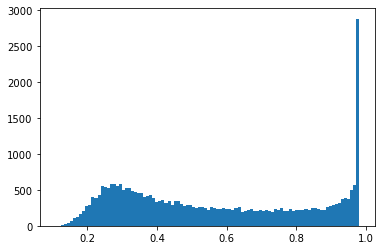

In [8]:
plt.hist(a.gini, bins=100)
plt.show()

## 5. HPA specificity metrics

### 5.1. HPA categories and noise threshold

HPA definitions of the tissue expression categories are available on this page: https://www.proteinatlas.org/about/assays+annotation#classification_rna

There are two dimensions: **specificity** and **distribution.**

They use the same threshold (nTPM > 1) for filtering out noise as we do in these calculations. Their definitions appear to be sensible, however, quite arbitrary, which is obvious from their use of cut-offs such as "a third" or "four times".

In [9]:
def hpa_specificity(row):
    expr = sorted(row)
    if expr[-1] < THRESHOLD:
        return 'Not detected'
    if expr[-2] == 0 or expr[-1]/expr[-2] >= 4.0:
        return 'Tissue enriched'
    for i in range(2, 6):
        if expr[-i-1] == 0 or expr[-i] / expr[-i-1] >= 4.0:
            return 'Group enriched'
    mean = sum(expr) / len(row)
    if 1 <= sum([e / mean >= 4.0 for e in expr]) <= 5:
        return 'Tissue enhanced'
    return 'Low tissue specificity'

def hpa_distribution(row):
    expr = sorted(row)
    if expr[-1] < THRESHOLD:
        return 'Not detected'
    num_detected = sum([e > THRESHOLD for e in expr])
    if num_detected == 1:
        return 'Detected in single'
    if num_detected < len(row) / 3:
        return 'Detected in some'
    if num_detected < len(row):
        return 'Detected in many'
    return 'Detected in all'

a['hpa_specificity'] = df.apply(hpa_specificity, axis=1)
a['hpa_distribution'] = df.apply(hpa_distribution, axis=1)
a

,gini,hpa_specificity,hpa_distribution
Name,,,
ENSG00000227232,0.278155,Low tissue specificity,Detected in many
ENSG00000268903,0.655462,Tissue enhanced,Detected in many
ENSG00000269981,0.666002,Tissue enhanced,Detected in many
ENSG00000239906,0.898719,Tissue enhanced,Detected in some
ENSG00000279928,0.685379,Tissue enriched,Detected in single
...,...,...,...
ENSG00000198695,0.284763,Low tissue specificity,Detected in all
ENSG00000210194,0.355988,Low tissue specificity,Detected in all
ENSG00000198727,0.245582,Low tissue specificity,Detected in all


## 6. Compute Adatiss specificity scores

[Link to paper](https://academic.oup.com/bioinformatics/article/37/23/4469/6306407)

In [10]:
# Prepare Adatiss input file. Original column names cannot be ingested by Adatiss because they contain special characters. Hence temporary identifiers are used for Adatiss.
column_map = {original_name: f"tissue_{i}" for i, original_name in enumerate(df.columns)}
reverse_column_map = {v: k for k, v in column_map.items()}
df.rename(columns=column_map).to_csv("adatiss_input.csv", index=True)

In [11]:
# Adatiss also requires a sample to tissue name map file.
with open('adatiss_sample_phenotype.csv', 'w') as outfile:
    outfile.write('sample_ID,tissue\n')
    for original_name, adatiss_name in column_map.items():
        outfile.write(f'{adatiss_name},{original_name}\n')

In [12]:
# Clone the Adatiss repository and apply a hot fix for a mathematical bug
! rm -rf AdaTiSS && git clone -q https://github.com/mwgrassgreen/AdaTiSS
! sed -i 's/if (length(y\.1) >= 20)/if (length(y.1) >= 20 \&\& length(unique(y.1)) > 1)/g' AdaTiSS/R/AdaTiSS_fn.R

In [13]:
%%R

# Run the computations

source('./AdaTiSS/R/AdaTiSS_fn.R')
dat.rna = read.csv(file='./adatiss_input.csv', row.names=1)
X = preproc.filter.fn(dat.rna, dat.type = "TPM or RPKM", proc.zero = 'ceiled to 1', filter.col.prp = 1, exp.thres = 1)
p.dat = read.csv('./adatiss_sample_phenotype.csv')
tiss.abd = tiss.abd.fn(X, p.dat)
result = AdaTiSS(X, tiss.abd=tiss.abd, adjust=TRUE, adjust.opt=0)
write.table(result$ada.s, file = "./adatiss_output.tsv", sep = "\t", quote = FALSE, row.names = TRUE)

[1] 500
[1] 1000
[1] 1500
[1] 2000
[1] 2500
[1] 3000
[1] 3500
[1] 4000
[1] 4500
[1] 5000
[1] 5500
[1] 6000
[1] 6500
[1] 7000
[1] 7500
[1] 8000
[1] 8500
[1] 9000
[1] 9500
[1] 10000
[1] 10500
[1] 11000
[1] 11500
[1] 12000
[1] 12500
[1] 13000
[1] 13500
[1] 14000
[1] 14500
[1] 15000
[1] 15500
[1] 16000
[1] 16500
[1] 17000
[1] 17500
[1] 18000
[1] 18500
[1] 19000
[1] 19500
[1] 20000
[1] 20500
[1] 21000
[1] 21500
[1] 22000
[1] 22500
[1] 23000
[1] 23500
[1] 24000
[1] 24500
[1] 25000
[1] 25500
[1] 26000
[1] 26500
[1] 27000
[1] 27500
[1] 28000
[1] 28500
[1] 29000
[1] 29500
[1] 30000
[1] 30500
[1] 31000
[1] 31500


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [14]:
# Read the results.
adatiss = pd.read_table("adatiss_output.tsv")
adatiss.rename(columns=reverse_column_map, inplace=True)
adatiss

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
ENSG00000227232,0.387857,0.044690,-0.372727,0.380429,0.312583,0.185383,0.827503,-1.518619,-1.219846,-1.362774,...,1.082426,1.143191,0.445551,1.080361,-0.131576,0.655744,1.184599,1.435200,1.023493,-0.398931
ENSG00000268903,-0.050832,0.496878,0.095292,0.086940,0.073609,-0.991954,0.040693,-1.041696,-1.102778,-1.395384,...,0.647509,0.693028,0.384310,3.053241,0.075008,2.755504,1.219419,0.239213,1.118411,4.347284
ENSG00000269981,0.004120,0.398468,0.226853,0.186657,0.023021,-0.650469,0.060835,-1.351962,-1.513653,-1.332618,...,0.626217,0.692679,0.467112,2.547492,0.197949,2.229452,1.094000,0.257616,0.989228,3.440013
ENSG00000239906,-0.228142,-0.228142,-0.228142,-0.228142,-0.228142,-0.228142,-0.228142,-0.228142,-0.228142,-0.228142,...,-0.228142,-0.228142,-0.228142,2.722479,-0.228142,2.279362,-0.228142,-0.228142,-0.228142,6.141721
ENSG00000279928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,188.232611,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,-0.837431,-0.799416,0.224678,0.156991,-0.258307,-0.375927,0.593400,0.847266,0.602256,1.146149,...,0.718778,0.560341,0.870152,-0.096669,0.846742,-2.076474,-1.394734,-0.778212,-1.593897,-3.008431
ENSG00000210194,-0.803149,-0.890206,0.228050,0.120984,-0.016644,-0.189100,0.399229,0.957825,0.587267,1.908344,...,0.657724,0.586310,0.763737,0.258364,0.682111,-2.844500,-1.836432,-1.001166,-1.854168,-2.561568
ENSG00000198727,0.155493,0.302684,0.565802,-1.174228,-0.717740,-1.152147,0.139417,0.856849,0.531410,1.330387,...,-0.330358,-0.550126,0.216737,-1.412068,0.441226,-0.801769,-0.239977,-0.846495,-1.193806,-4.915172
ENSG00000210195,-0.616127,-0.616127,0.102028,-0.616127,-0.616127,-0.616127,-0.616127,1.541751,1.559448,2.383715,...,-0.616127,-0.428343,-0.616127,-0.616127,-0.616127,-0.616127,-0.616127,-0.616127,-0.616127,-0.616127


## 7. Pack the data for output

In [15]:
df_name_mapping = pd.read_table("/home/ktsukanov/repositories/open-targets/curation/mappings/biosystem/gtex_v8_tissues.tsv")
name_mapping = {
    gtex_tissue: ontology_code
    for gtex_tissue, ontology_code
    in df_name_mapping[["gtex_tissue_name", "ontology_code"]].values.tolist()
}

In [16]:
for tissue in df.columns:
    if tissue not in name_mapping:
        raise AssertionError(f"GTEx tissue {tissue} is not present in the provided mappings file")

In [17]:
# Pack Adatiss results for output.

def pack_adatiss_row(row):
    """Given a row with Adatiss results for a given gene, pack them into the list of (tissue, z-score) values ready for output."""
    # Extract the column names and values from the row
    cols = adatiss.columns
    vals = row.values.tolist()

    # Pack the values into a list of dictionaries
    dicts = []
    for col, val in zip(cols, vals):
        dicts.append({"bodyPartLevel": "tissue", "bodyPartName": col, "bodyPartId": name_mapping[col], "adatissScore": round(val, 3)})

    return dicts

In [18]:
# Map annotation names.
annotation_column_map = {
    'gini': 'gini', 
    'hpa_specificity': 'hpaSpecificity',
    'hpa_distribution': 'hpaDistribution'
}
columns_to_filter = list(annotation_column_map.keys())
a_out = (
    a
    [columns_to_filter]
    .rename(columns=annotation_column_map)
)
a_out['gini'] = a_out['gini'].round(3)
a_out['adatissScores'] = adatiss.apply(pack_adatiss_row, axis=1)
a_out

,gini,hpaSpecificity,hpaDistribution,adatissScores
Name,,,,
ENSG00000227232,0.278,Low tissue specificity,Detected in many,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000268903,0.655,Tissue enhanced,Detected in many,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000269981,0.666,Tissue enhanced,Detected in many,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000239906,0.899,Tissue enhanced,Detected in some,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000279928,0.685,Tissue enriched,Detected in single,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
...,...,...,...,...
ENSG00000198695,0.285,Low tissue specificity,Detected in all,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000210194,0.356,Low tissue specificity,Detected in all,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000198727,0.246,Low tissue specificity,Detected in all,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."


In [19]:
# Pack and output the data.

def remove_adatiss_if_none(d):
    if d['adatissScores'] != d['adatissScores']:  # using the fact that NaN != NaN
        return {k: v for k, v in d.items() if k != 'adatissScores'}
        print('removed')
    else:
        return d

# Create a list to store JSON objects
json_list = []

# Iterate over each row index
for idx in df.index:
    # Create a dictionary for the current row
    row_dict = {
        "ensemblGeneId": idx,
        "expression": [
            {
                "bodyPartLevel": "tissue",
                "bodyPartId": key,
                "bodyPartName": name_mapping[key],
                "tpm": value,
            }
            for key, value
            in df.loc[idx].to_dict().items()
        ],
        "expressionSpecificity": remove_adatiss_if_none(a_out.loc[idx].to_dict())
    }
    # Append the dictionary to the list
    json_list.append(row_dict)

In [24]:
with gzip.open("expression_v2.1.jsonl.gz", "wt", compresslevel=9) as f:
    for obj in json_list:
        f.write(json.dumps(obj))
        f.write('\n')

In [25]:
# Output one example record.
print(json.dumps(json_list[0]))

{"ensemblGeneId": "ENSG00000227232", "expression": [{"bodyPartLevel": "tissue", "bodyPartId": "Adipose - Subcutaneous", "bodyPartName": "UBERON:0002190", "tpm": 4.06403}, {"bodyPartLevel": "tissue", "bodyPartId": "Adipose - Visceral (Omentum)", "bodyPartName": "UBERON:0010414", "tpm": 3.37111}, {"bodyPartLevel": "tissue", "bodyPartId": "Adrenal Gland", "bodyPartName": "UBERON:0002369", "tpm": 2.68549}, {"bodyPartLevel": "tissue", "bodyPartId": "Artery - Aorta", "bodyPartName": "UBERON:0001496", "tpm": 4.04762}, {"bodyPartLevel": "tissue", "bodyPartId": "Artery - Coronary", "bodyPartName": "UBERON:0001621", "tpm": 3.90076}, {"bodyPartLevel": "tissue", "bodyPartId": "Artery - Tibial", "bodyPartName": "UBERON:0007610", "tpm": 3.63963}, {"bodyPartLevel": "tissue", "bodyPartId": "Bladder", "bodyPartName": "UBERON:0001255", "tpm": 5.16375}, {"bodyPartLevel": "tissue", "bodyPartId": "Brain - Amygdala", "bodyPartName": "UBERON:0001876", "tpm": 1.43859}, {"bodyPartLevel": "tissue", "bodyPartId"

In [ ]:
# Ingest the data back and print the schema.
df = spark.read.format("json").option("compression", "gzip").load("expression_v2.1.jsonl.gz")
df.printSchema()